# GT4Py Concepts

This notebook walks through the major concepts of the [GT4Py](https://github.com/GridTools/gt4py) stencil library. The concepts are exposed with the aid of some illustrative examples which are particularly relevant in weather and climate.

In [1]:
import gt4py.next as gtx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["font.size"] = 16

## Defining a stencil computation

Horizontal advection by the mean flow represents a major driving force for atmospheric dynamics. Consider the conserved quantity $\phi = \rho \psi$, where $\rho$ is the air density and $\psi$ a specific quantity. Its transport by the steering wind $(u, \, v)$ is governed by the equation

\begin{equation}
    \frac{\partial \phi}{\partial t} + \frac{\partial u \phi}{\partial x} + \frac{\partial v \phi}{\partial y} = 0 \, .
\end{equation}

(Observe that $\psi \equiv 1$ discloses the continuity equation.) An established way to discretize this equation on a Cartesian grid is by centered spatio-temporal differencing:

\begin{equation}
    \frac{\phi^{n+1}_{i,j} - \phi^{n-1}_{i,j}}{2 \Delta t} + \frac{u_{i+1,j}^n \, \phi_{i+1,j}^n  -  u_{i-1,j}^n \, \phi_{i-1,j}^n}{2 \Delta x} + \frac{v_{i,j+1}^n \, \phi_{i,j+1}^n - v_{i,j-1}^n \, \phi_{i,j-1}^n}{2 \Delta y} = 0 \, .
\end{equation}

This method is commonly known as the leapfrog scheme. Here $\Delta x$ and $\Delta y$ are the grid spacings in the $x$- and $y$-direction, $\Delta t$ is the time-step and for a generic variable $\xi = \xi(x, \, y, \, t)$ we denote by $\xi_{i,j}^n$ the numerical approximation of $\xi(i \Delta x, \, j \Delta y, \, n \Delta t)$. 

![grid](img/grid.png)

The formula which advances the solution forward in time is found to be

\begin{equation}
    \phi_{i,j}^{n+1} = \phi_{i, j}^{n-1} - \frac{\Delta t}{\Delta x} \left( u_{i+1,j}^n \, \phi_{i+1,j}^n - u_{i-1,j}^n \, \phi_{i-1,j}^n \right) - \frac{\Delta t}{\Delta y} \left( v_{i,j+1}^n \, \phi_{i,j+1}^n - v_{i,j-1}^n \, \phi_{i,j-1}^n  \right) \, .
\end{equation}

We recognize the update operator as a stencil computation. The field $\phi^{n+1}$ at $(i, \, j)$ (blue point in the figure below) is computed by accessing $\phi^{n-1}$ at $(i, \, j)$ and $\phi^n$, $u^n$ and $v^n$ at the neignboring points $(i-1, \, j)$, $(i+1, \, j)$, $(i, \, j-1)$ and $(i, \, j+1)$ (red points).

![stencil](img/stencil.png)

GT4Py is a domain-specific language (DSL) to express stencil computations as regular Python functions. 

In [2]:
I = gtx.Dimension("I")
J = gtx.Dimension("J")
K = gtx.Dimension("K", kind=gtx.DimensionKind.VERTICAL)

IJKField = gtx.Field[gtx.Dims[I, J, K], gtx.float64]

@gtx.field_operator
def leapfrog(
    u: IJKField,
    v: IJKField,
    phi_old: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
) -> IJKField:
    dphi_dx = phi_now(I + 1) * u(I + 1) - phi_now(I - 1) * u(I - 1) / (2.0 * dx)
    dphi_dy = phi_now(J + 1) * v(J + 1) - phi_now(J - 1) * v(J - 1) / (2.0 * dy)
    phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)
               
    return phi_new

Let's dissect the definition function block-by-block.

* All input parameters must be annotated. GT4Py next offers the type descriptor `Field` for data fields. This descriptor is parametric in the dimensions and the data-type. Supported data-types are: `gtx.float64`, `gtx.float32`, `gtx.int32`, etc.
* The `@gtx.field_operator` ensures that the function is pure, or side effect free: its signature includes only read-only fields (`u`, `v`, `phi_old`, `phi_now`) and read-only scalar coefficients (`dt`, `dx`, `dy`), the output is automatically the return value.  More on pure functions below.
* Accessing neighbors is done by shifting the fields with the `field(I + 1)` syntax, where `I` denotes the dimension and `+ 1` an offset in that dimension. Have a look at the figure below for a schematic visualization of how a field with halo is shifted in `I - 1` and `I + 1`.
* Note that for loops are abstracted away and operations are performed for all elements of a field implicitly, similar to NumPy or CuPy. You may think each operation as the result of an `ij`-loop on the equivalent scalar operation.

![input](img/fieldview_lap_2.png)

#### Note on pure functions:
One instructive view of pure functions is that they cannot have any side effects, for example the call to a `print` function. The following function computes the square of a number `a` and also prints the word "Hello".

In [3]:
def square(a):
    print("Hello")
    return a*a

# Prints Hello twice
b = square(2)
b = square(2)

Hello
Hello


The result of the function is 4, but the side effect is the printing of the "Hello". We say `square` has a side effect. The side effect "Hello" allows us to see if `square(2)` was executed once or twice. We can check the terminal if "Hello" was printed once or twice.

If we remove the print from the function:

In [4]:
def square(a):
    return a*a

# We can no longer tell if there was one or two executions
b = square(2)
b = square(2)

We can no longer say if the function was executed once or twice, except by looking at the code, the result value in b is the same (4) and there is no side effect.
We can say `square(a)` is side-effect free, or pure.

Pure functions often appear in scientific computing, since most of our computations are data-in data-out methods without side effects.
Pure functions have some very big upsides, for example, they are very easy to predict in their behavior/effect

## Fields

GT4Py's data storages are fields on structured (or unstructured) grids. The following figure shows how the array elements (green boxes) map to the grid points (grey dots). The pairs between square brackets represent the element indices in a horizontal slice of the storage.

![storage](img/storage.png)

Fields in GT4Py are multi-dimensional arrays on a domain with named dimensions. This is implemented by wrapping a NumPy or CuPy array and adding the domain specific operations to the field interface (often just dispatching to the NumPy or CuPy implementation). To access the underlying array you can use `field.ndarray` (CuPy or NumPy array) or `field.asnumpy()` to convert it to NumPy.

The user interface hides as much as possible all low-level and backend-specific details, like the memory layout, strides, padding, etc.. All these aspects are handled internally by GT4Py in a transparent fashion.

In [5]:
# different possible backends
#backend = None             # Embedded, native Python execution
backend = gtx.gtfn_cpu     # Translated to C++ code (with simple OpenMP pragmas)
#backend = gtx.gtfn_gpu     # Translated to GPU (CUDA or HIP) code

# defining dimensions
I = gtx.Dimension("I")
J = gtx.Dimension("J")
K = gtx.Dimension("K", kind=gtx.DimensionKind.VERTICAL)

# sizes and origins
field_domain = gtx.domain({
    I: (-1, 513),
    J: (-1, 513),
    K: (0, 128),
})

u = gtx.zeros(field_domain, dtype=gtx.float64, allocator=backend)
v = gtx.ones(field_domain, dtype=gtx.float64, allocator=backend)

In [6]:
# define helper function to create random fields
def random_field(domain, allocator=None):
    return gtx.as_field(
        domain, np.random.rand(*field_domain.shape), allocator=allocator
    )

In [7]:
# define three random fields
phi_old = random_field(field_domain, allocator=backend)
phi_now = random_field(field_domain, allocator=backend)
phi_new = random_field(field_domain, allocator=backend)

We can use `.asnumpy()` to convert a GT4Py field into a plain NumPy array.

In [8]:
# prints the domain of the field
print("-- Domain of phi_old --")
print(phi_old)

# prints the content of phi_old
print("\n")
print("-- Content of phi_old --")
print(phi_old.asnumpy())

-- Domain of phi_old --
⟨Domain(I[horizontal]=(-1:513), J[horizontal]=(-1:513), K[vertical]=(0:128)) → DType(scalar_type=<class 'numpy.float64'>, tensor_shape=())⟩


-- Content of phi_old --
[[[3.50786707e-01 9.47302002e-01 6.48200108e-01 ... 6.88140834e-01
   9.53209235e-01 9.51930889e-01]
  [9.81606065e-01 2.44993614e-01 6.84530116e-01 ... 2.53890578e-01
   6.91996989e-01 5.41421435e-01]
  [2.39079826e-01 6.42539390e-01 8.38200660e-01 ... 3.12502803e-02
   1.99845584e-01 4.62117869e-01]
  ...
  [6.69169570e-01 3.80462948e-01 1.29364046e-01 ... 3.25610572e-01
   1.15506237e-01 1.81131753e-01]
  [4.89396772e-01 9.16517708e-01 8.54759812e-01 ... 4.07747642e-01
   2.77183190e-01 6.15366487e-01]
  [5.82306663e-02 8.95370597e-01 2.88368095e-01 ... 9.34148200e-01
   2.50934425e-01 6.14689851e-01]]

 [[5.49377331e-01 6.87530043e-01 5.53081559e-02 ... 7.81800509e-01
   6.94312583e-01 1.72121809e-03]
  [8.14462213e-01 3.56074511e-01 2.17819525e-01 ... 9.77239847e-01
   3.99279579e-01 7.5669950

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>1.</b> Create a field <tt>a</tt> for each backend `None`, `gtx.gtfn_cpu` and `gtx.gtfn_gpu`, for the `field_domain` defined above, using the `random_field` function. Investigate the sizes and strides of the generated fields using the <tt>strides</tt> attribute of a <tt>numpy.ndarray</tt>. For each backend try to infer the memory layout from the strides. Do your findings agree with what we have discussed over this week? <br>
    <b>2.</b> Add a `dtype` argument to the `random_field` method so you can choose between creating fields of data type `np.float32` and `np.float64`. <br>
    <b>3.</b> The function <tt>plot_slice</tt> tries to visualize <tt>a[:, :, 0]</tt>. Check yourself that the function raises an exception with any backend. How could you make it work? 
</div>

In [9]:
# TODO - create a storage for each of the 3 backends, investigate the domains 

print(field_domain.shape)

a = random_field(field_domain, allocator=None)
print(a)
print(a.ndarray.strides)

a = random_field(field_domain, allocator=gtx.gtfn_cpu)
print(a)
print(a.ndarray.strides)

a = random_field(field_domain, allocator=gtx.gtfn_gpu)
print(a)
print(a.ndarray.strides)

(514, 514, 128)
⟨Domain(I[horizontal]=(-1:513), J[horizontal]=(-1:513), K[vertical]=(0:128)) → DType(scalar_type=<class 'numpy.float64'>, tensor_shape=())⟩
(8, 4160, 2138240)
⟨Domain(I[horizontal]=(-1:513), J[horizontal]=(-1:513), K[vertical]=(0:128)) → DType(scalar_type=<class 'numpy.float64'>, tensor_shape=())⟩
(8, 4160, 2138240)
⟨Domain(I[horizontal]=(-1:513), J[horizontal]=(-1:513), K[vertical]=(0:128)) → DType(scalar_type=<class 'numpy.float64'>, tensor_shape=())⟩
(8, 4224, 2171136)


In [ ]:
from gt4py.next.iterator.embedded import MutableLocatedField

# TODO - create a random_field method with an additional parameter dtype
# define helper function enabling random fields
def random_field(
    domain: gtx.Domain, low: float = -1.0, high: float = 1.0, *, allocator=None, dtype=np.float64
) -> MutableLocatedField:
    # return as gt4py field
    return gtx.as_field(
        domain,
        # create numpy/cupy array depending on the allocator
        np.random.default_rng().uniform(low=low, high=high, size=domain.shape).astype(dtype),
        allocator=allocator,
        dtype=dtype,
    )

In [ ]:
# TODO - create a float32 storage for each of the 3 backends, investigate the domains 

print(field_domain.shape)

a = random_field(field_domain, allocator=None, dtype=np.float32)
print(a)
print(a.ndarray.strides)

a = random_field(field_domain, allocator=gtx.gtfn_cpu, dtype=np.float32)
print(a)
print(a.ndarray.strides)

a = random_field(field_domain, allocator=gtx.gtfn_gpu)
print(a)
print(a.ndarray.strides)

In [10]:
def plot_slice(field):
    fig, ax = plt.subplots(1, 1)
    # TODO - fix the line below
    im = ax.imshow(field.asnumpy()[:,:,0], origin="lower", vmin=0, vmax=1)
    fig.colorbar(im, cmap="magma", ax=ax)
    ax.set_xticks(range(0, 513, 128))
    ax.set_yticks(range(0, 513, 128))
    plt.show()

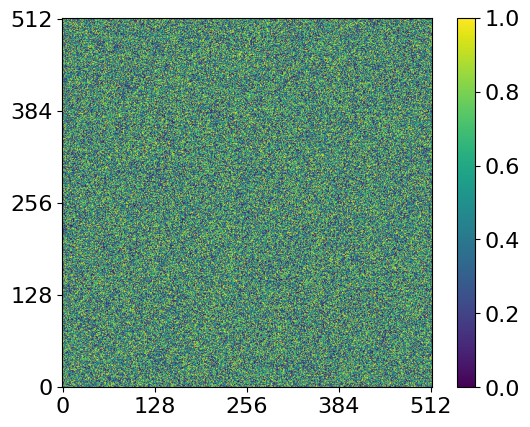

In [11]:
plot_slice(a)

## Running a stencil

GT4Py can generate high-performance implementations of a stencil starting from its definition function. The GT4Py pipeline relies on the [GridTools (GT) framework](https://github.com/GridTools) to produce native implementations for different platforms. The piece of software in charge of synthetizing optimized code for a specific hardware architecture is called **backend**. The default is *no* backend (`backend=None`) which runs the program natively in Python (using NumPy/CuPy under the hood).

In [12]:
backend = gtx.gtfn_cpu
leapfrog_stencil = leapfrog.with_backend(backend) # creates a program with the given backend

In this course we use the following backends

* `None`: execution directly in Python, natively, using numpy or cupy
* `gtx.gtfn_cpu`: produces C++ GT-based code devised for a generic CPU;
* `gtx.gtfn_gpu`: produces C++ GT-based code for NVIDIA GPUs.

## Running computations

Executing stencil computations is as simple as a function call:

In [13]:
compute_domain = gtx.domain({
    I: (0, 512),
    J: (0, 512),
    K: (0, 128),
})

leapfrog(
    u=u,
    v=v,
    phi_old=phi_old,
    phi_now=phi_now,
    dt=1.0,
    dx=1.0,
    dy=1.0,
    out=phi_new,
    domain=compute_domain,
)

The field operator retains the same signature of its definition function and adds two additional parameters: `out` and `domain`. The former specifies where the data should be written to (here `phi_new` defined as a random field above) and serves as a non-functional entry point to the DSL for interfacing with surrounding code. The `domain` is the region where we want to compute values for `out`.

![halo](img/halo.png)

The blue area denotes the computation domain, i.e. where values for `phi_new` can be computed and stored. On the other hand, the red boxes form the **boundary region** where values for `phi_new` cannot be calculated, but where the input fields `u`, `v` and `phi_now` are read. It should be remarked that the figure showcases the *largest* possible computation domain, see that it goes from 0 to 512 in I and J, which is one "cell" less than what our `field_domain` is where we definded I and J from -1 to 513. It is possible to restrict the application of the stencil to a subset of the largest feasible computation domain. Keep in mind the computation must never access areas outside of the domain. In Python execution you will get an error indicating mismatching domains, (currently - to be improved) you might get a segmentation fault / cuda memory error in the compiled backends.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>4.</b> Run the <tt>leapfrog</tt> stencil in the domain <tt>(I:(0, 512), J:(0, 512), K:(0, 128))</tt>. Do the computations run for any domain size? <br>
    <b>5.</b> Write a simple stencil which sets a field equal to <tt>1</tt>. Instantiate it using the <tt>None</tt> backend. Assume then it is fed with a field of domain <tt>(I:(0, 128), J:(0, 128), K:(0, 64))</tt>, filled with zeros, and it is invoked employing either (i) <tt>(I:(32, 64), J:(32, 64), K:(0, 64))</tt>, or (ii) <tt>(I:(64, 64), J:(0, 128), K:(0, 64))</tt>. Can you guess which is the result in both cases? Assess the correctness of your ideas using the function <tt>validate_to_one</tt>.
</div>

In [14]:
compute_domain = gtx.domain({
    I: (0, 512), # TODO
    J: (0, 512), # TODO
    K: (0, 128), # TODO
})

leapfrog(
    u=u,
    v=v,
    phi_old=phi_old,
    phi_now=phi_now,
    dt=1.0,
    dx=1.0,
    dy=1.0,
    out=phi_new,
    domain=compute_domain,
)

In [15]:
from gt4py.next import broadcast

field_domain = gtx.domain({
    I: (0, 128),
    J: (0, 128),
    K: (0, 64),
})

compute_domain_1 = gtx.domain({
    I: (32, 64),
    J: (32, 64),
    K: (0, 64),
})

compute_domain_2 = gtx.domain({
    I: (64, 64),
    J: (0, 128),
    K: (0, 64),
})

@gtx.field_operator
def to_one_defs(a: IJKField) -> IJKField:
    return broadcast(1.0, (I,J,K))

In [16]:
backend=None
to_one = to_one_defs.with_backend(backend=backend)

In [17]:
def validate_to_one(stencil):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    a = gtx.zeros(field_domain, dtype=gtx.float64, allocator=backend)
    
    stencil(a=a, out=a, domain=compute_domain_1)
    im0 = axs[0].imshow(a.ndarray[:, :, 0], origin="lower", vmin=0, vmax=1)
    axs[0].set_title("Case (i)")
    axs[0].set_xlabel("i")
    axs[0].set_xticks(range(0, 129, 32))
    axs[0].set_ylabel("j")
    axs[0].set_yticks(range(0, 129, 32))
    
    a[...] = 0.0
    stencil(a=a, out=a, domain=compute_domain_2)
    im1 = axs[1].imshow(a.ndarray[:, :, 0].transpose(), origin="lower", vmin=0, vmax=1)
    fig.colorbar(im1, cmap="magma", ax=[axs[0], axs[1]])
    axs[1].set_title("Case (ii)")
    axs[1].set_xlabel("i")
    axs[1].set_xticks(range(0, 129, 32))
    axs[1].set_yticks(range(0, 129, 32))
    
    plt.show()

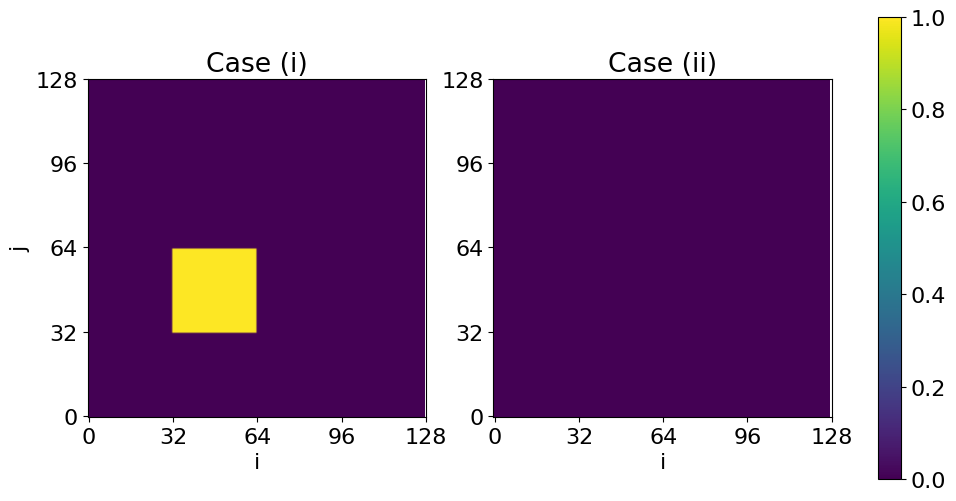

In [18]:
validate_to_one(to_one)

## Functions

GT4Py allows the user to call field operators within field operators. As we learned, field operators can accept both fields and scalar coefficients, performs stencil operations, and eventually returns one or multiple fields. In the context of embedded execution (`backend=None`) there is overhead associated with calling additional field operators, just like in regular Python. However, in case of the compiled backends, this is not always true, since inlining can be done by a compiler.

In [19]:
@gtx.field_operator
def centered_diff_x(
    u: IJKField,
    phi: IJKField,
    dx: gtx.float64,
) -> IJKField:
    return (phi(I + 1) * u(I + 1) - phi(I - 1) * u(I - 1)) / (2.0 * dx)

@gtx.field_operator
def centered_diff_y(
    v: IJKField,
    phi: IJKField,
    dy: gtx.float64,
) -> IJKField:
    return (phi(J + 1) * v(J + 1) - phi(J - 1) * v(J - 1)) / (2.0 * dy)

@gtx.field_operator
def leapfrog_functions_defs(
    u: IJKField,
    v: IJKField,
    phi_old: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
) -> IJKField:
    
    dphi_dx = centered_diff_x(u, phi_now, dx)
    dphi_dy = centered_diff_y(v, phi_now, dy)
    phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)
    
    return phi_new

In [20]:
leapfrog_stencil = leapfrog.with_backend(backend)

dt=1.0
dx=1.0
dy=1.0

%timeit leapfrog_stencil(u=u, v=v, phi_old=phi_old, phi_now=phi_now, dt=dt, dx=dx, dy=dy, out=phi_new, domain=field_domain)

418 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The systematic use of functions may avoid duplicated code and improve readability, without introducing unacceptable overheads. The latter statement can be easily validated on our simple example:

## Run-time conditionals

GT4Py supports all binary operators (e.g. sum, difference, multiplication, etc) and ternary operators. The latter are also known as conditional expressions in Python, and can be used to calculate the absolute value of a scalar:

In [21]:
@gtx.field_operator
def absolute_value_field(phi: gtx.float64):
    return phi if phi > 0.0 else -phi

Similarly to Numpy and Cupy, for fields we can express a ternary operator as a `where`, as follows:

In [22]:
from gt4py.next import where

@gtx.field_operator
def absolute_value_pointwise(phi: IJKField):
    out = where(
        phi > 0.0,
        phi,
        -phi,
    )

    return out

Another notable example where run-time conditionals come in handy is the numerical integration of the hyperbolic equation

\begin{equation}
    \frac{\partial \phi}{\partial t} + \frac{\partial \phi u}{\partial x} + \frac{\partial \phi v}{\partial y} = 0 \, .
\end{equation}

by the upwind scheme:

\begin{equation}
    F_{i,j} =
    \begin{cases}
        & \left( \phi_{i,j} \, u_{i,j} - \phi_{i-1,j} \, u_{i-1,j} \right) / \Delta x \qquad \text{if $u_{i,j} > 0$} \\
        & \left( \phi_{i+1,j} \, u_{i+1,j} - \phi_{i,j} \, u_{i,j} \right) / \Delta x \qquad \text{if $u_{i,j} <= 0$}
    \end{cases} \\
    G_{i,j} =
    \begin{cases}
        & \left( \phi_{i,j} \, v_{i,j} - \phi_{i,j-1} \, v_{i,j-1} \right) / \Delta y \qquad \text{if $v_{i,j} > 0$} \\
        & \left( \phi_{i,j+1} \, v_{i,j+1} - \phi_{i,j} \, v_{i,j} \right) / \Delta y \qquad \text{if $v_{i,j} <= 0$}
    \end{cases} \\
    \phi_{i,j}^{n+1} = \phi_{i,j}^n - \Delta t \left( F_{i,j}^n + G_{i,j}^n \right) \, .
\end{equation}

In [23]:
from gt4py.next import where

@gtx.field_operator
def upwind_diff_x(
    u: IJKField,
    phi: IJKField,
    dx: gtx.float64,
) -> IJKField:
    out = where(
        u > 0.0,
        (phi * u - phi(I - 1) * u(I - 1)) / dx,
        (phi(I + 1) * u(I + 1) - phi* u) / dx,
    )
    
    return out

@gtx.field_operator
def upwind_diff_y(
    v: IJKField,
    phi: IJKField,
    dy: gtx.float64,
) -> IJKField:
    out = where(
        v > 0.0,
        (phi * v - phi(J - 1) * v(J -1)) / dy,
        (phi(J + 1) * v(J + 1) - phi * v) / dy,
    )
  
    return out

@gtx.field_operator
def upwind(
    u: IJKField,
    v: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
) -> IJKField:

    dphi_dx = upwind_diff_x(u, phi_now, dx)
    dphi_dy = upwind_diff_y(v, phi_now, dy)
    phi_new = phi_now - dt * (dphi_dx + dphi_dy)
    
    return phi_new
        
upwind_stencil = upwind.with_backend(backend)

## Compile-time conditionals

A more sophisticated control flow statement consists of an if-else construct which queries a **scalar** quantity whose value is known at the stencil compile-time. Such a scalar quantity can be taken into account during instantiation of a stencil for a backend. An example for this could be a configuration option `upwinding` which regulates the type of advection scheme to use. This technique allows to fuse the `leapfrog` and `upwind` stenci|ls into a unique stencil.

In [24]:
@gtx.field_operator
def horizontal_advection_(
    u: IJKField,
    v: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
    upwinding: bool,
) -> IJKField:
    
    if (upwinding):
        dphi_dx = upwind_diff_x(u, phi_now, dx)
        dphi_dy = upwind_diff_y(v, phi_now, dy)
    else:
        dphi_dx = centered_diff_x(u, phi_now, dx)
        dphi_dy = centered_diff_y(v, phi_now, dy)
            
    phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)
    
    return phi_new


@gtx.program
def horizontal_advection(
    u: IJKField,
    v: IJKField,
    phi_now: IJKField,
    phi_new: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
    upwinding: bool,
):
    horizontal_advection_(
        u,
        v,
        phi_now,
        dt,
        dx,
        dy,
        upwinding,
        out=phi_new,
    )

horizontal_advection_stencil = horizontal_advection.with_backend(gtx.gtfn_gpu).compile(upwinding = [True], offset_provider={})

You might have noticed that a `.gt4py_cache` folder exists in the folder where you run GT4Py programs with backends `gtx.gtfn_cpu` or `gtx.gtfn_gpu`. The reason is that GT4Py compiles stencils during their first execution and then saves these compiled stencils in the cache folder to speed up the next execution. <br>
In case we are using the `.compile()` function above, we are pre-compiling the stencil for a certain backend with certain options (in our case `upwinding=True`), in this case during the first execution the stencil is already in cache and can be used immediately.